
**Building a Search Engine - Introduction**

This week we will download and run a simple version of the Google PageRank Algorithm.  Here is an early paper by Larry Page and Sergy Brin, the founders of Google, that describes their early thoughts about the algorithm:

http://infolab.stanford.edu/~backrub/google.html

We will provide you with sample code and lectures that walk through the sample code:

https://www.py4e.com/code3/pagerank.zip

There is not a lot of new code to write - it is mostly looking at the code and making the code work.  You will be able to spider some simple content that we provide and then play with the program to spider some other content.  Part of the fun of this assignment is when things go wrong and you figure out how to solve a problem when the program wanders into some data that breaks its retrieval and parsing.  So you will get used to starting over with a fresh database and running your web crawl.


**STEP 1**

-  Run filenane = spider.py

-  Selected website =  https://en.wikipedia.org/wiki/Main_Page

-  How many pages: 500

In [ ]:


# 1) Page Rank - Spidering (Chaprter 16)
# File - spider.py


import sqlite3
import urllib.error
import ssl
from urllib.parse import urljoin
from urllib.parse import urlparse
from urllib.request import urlopen
from bs4 import BeautifulSoup



# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

cur.execute('''CREATE TABLE IF NOT EXISTS Pages
    (id INTEGER PRIMARY KEY, url TEXT UNIQUE, html TEXT,
     error INTEGER, old_rank REAL, new_rank REAL)''')

cur.execute('''CREATE TABLE IF NOT EXISTS Links
    (from_id INTEGER, to_id INTEGER, UNIQUE(from_id, to_id))''')

cur.execute('''CREATE TABLE IF NOT EXISTS Webs (url TEXT UNIQUE)''')

# Check to see if we are already in progress...
cur.execute('SELECT id,url FROM Pages WHERE html is NULL and error is NULL ORDER BY RANDOM() LIMIT 1')
row = cur.fetchone()
if row is not None:
    print("Re
# 1) Page Rank - Spidering (Chaprter 16)
# File - spider.py


import sqlite3
import urllib.error
importstarting existing crawl.  Remove spider.sqlite to start a fresh crawl.")
else :
    starturl = input('Enter web url or enter: ')
    if ( len(starturl) < 1 ) : starturl = 'https://en.wikipedia.org/wiki/Main_Page/'
    if ( starturl.endswith('/') ) : starturl = starturl[:-1]
    web = starturl
    if ( starturl.endswith('.htm') or starturl.endswith('.html') ) :
        pos = starturl.rfind('/')
        web = starturl[:pos]

    if ( len(web) > 1 ) :
        cur.execute('INSERT OR IGNORE INTO Webs (url) VALUES ( ? )', ( web, ) )
        cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( starturl, ) )
        conn.commit()

# Get the current webs
cur.execute('''SELECT url FROM Webs''')
webs = list()
for row in cur:
    webs.append(str(row[0]))

print(webs)

many = 0
while True:
    if ( many < 1 ) :
        sval = input('How many pages:')
        if ( len(sval) < 1 ) : break
        many = int(sval)
    many = many - 1

    cur.execute('SELECT id,url FROM Pages WHERE html is NULL and error is NULL ORDER BY RANDOM() LIMIT 1')
    try:
        row = cur.fetchone()
        # print row
        fromid = row[0]
        url = row[1]
    except:
        print('No unretrieved HTML pages found')
        many = 0
        break

    print(fromid, url, end=' ')

    # If we are retrieving this page, there should be no links from it
    cur.execute('DELETE from Links WHERE from_id=?', (fromid, ) )
    try:
        document = urlopen(url, context=ctx)

        html = document.read()
        if document.getcode() != 200 :
            print("Error on page: ",document.getcode())
            cur.execute('UPDATE Pages SET error=? WHERE url=?', (document.getcode(), url) )

        if 'text/html' != document.info().get_content_type() :
            print("Ignore non text/html page")
            cur.execute('DELETE FROM Pages WHERE url=?', ( url, ) )
            conn.commit()
            continue

        print('('+str(len(html))+')', end=' ')

        soup = BeautifulSoup(html, "html.parser")
    except KeyboardInterrupt:
        print('')
        print('Program interrupted by user...')
        break
    except:
        print("Unable to retrieve or parse page")
        cur.execute('UPDATE Pages SET error=-1 WHERE url=?', (url, ) )
        conn.commit()
        continue

    cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( url, ) )
    cur.execute('UPDATE Pages SET html=? WHERE url=?', (memoryview(html), url ) )
    conn.commit()

    # Retrieve all of the anchor tags
    tags = soup('a')
    count = 0
    for tag in tags:
        href = tag.get('href', None)
        if ( href is None ) : continue
        # Resolve relative references like href="/contact"
        up = urlparse(href)
        if ( len(up.scheme) < 1 ) :
            href = urljoin(url, href)
        ipos = href.find('#')
        if ( ipos > 1 ) : href = href[:ipos]
        if ( href.endswith('.png') or href.endswith('.jpg') or href.endswith('.gif') ) : continue
        if ( href.endswith('/') ) : href = href[:-1]
        # print href
        if ( len(href) < 1 ) : continue

		# Check if the URL is in any of the webs
        found = False
        for web in webs:
            if ( href.startswith(web) ) :
                found = True
                break
        if not found : continue

        cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( href, ) )
        count = count + 1
        conn.commit()

        cur.execute('SELECT id FROM Pages WHERE url=? LIMIT 1', ( href, ))
        try:
            row = cur.fetchone()
            toid = row[0]
        except:
            print('Could not retrieve id')
            continue
        # print fromid, toid
        cur.execute('INSERT OR IGNORE INTO Links (from_id, to_id) VALUES ( ?, ? )', ( fromid, toid ) )


    print(count)

cur.close()


**STEP 2**

-  Run filenane = sprank.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page

-  How many iterations: 500


In [ ]:

# 2) Page Rank - Computation (Chaprter 16)
# File - sprank.py


import sqlite3

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

# Find the ids that send out page rank - we only are interested
# in pages in the SCC that have in and out links
cur.execute('''SELECT DISTINCT from_id FROM Links''')
from_ids = list()
for row in cur: 
    from_ids.append(row[0])

# Find the ids that receive page rank 
to_ids = list()
links = list()
cur.execute('''SELECT DISTINCT from_id, to_id FROM Links''')
for row in cur:
    from_id = row[0]
    to_id = row[1]
    if from_id == to_id : continue
    if from_id not in from_ids : continue
    if to_id not in from_ids : continue
    links.append(row)
    if to_id not in to_ids : to_ids.append(to_id)

# Get latest page ranks for strongly connected component
prev_ranks = dict()
for node in from_ids:
    cur.execute('''SELECT new_rank FROM Pages WHERE id = ?''', (node, ))
    row = cur.fetchone()
    prev_ranks[node] = row[0]

sval = input('How many iterations:')
many = 1
if ( len(sval) > 0 ) : many = int(sval)

# Sanity check
if len(prev_ranks) < 1 : 
    print("Nothing to page rank.  Check data.")
    quit()

# Lets do Page Rank in memory so it is really fast
for i in range(many):
    # print prev_ranks.items()[:5]
    next_ranks = dict();
    total = 0.0
    for (node, old_rank) in list(prev_ranks.items()):
        total = total + old_rank
        next_ranks[node] = 0.0
    # print total

    # Find the number of outbound links and sent the page rank down each
    for (node, old_rank) in list(prev_ranks.items()):
        # print node, old_rank
        give_ids = list()
        for (from_id, to_id) in links:
            if from_id != node : continue
           #  print '   ',from_id,to_id

            if to_id not in to_ids: continue
            give_ids.append(to_id)
        if ( len(give_ids) < 1 ) : continue
        amount = old_rank / len(give_ids)
        # print node, old_rank,amount, give_ids
    
        for id in give_ids:
            next_ranks[id] = next_ranks[id] + amount
    
    newtot = 0
    for (node, next_rank) in list(next_ranks.items()):
        newtot = newtot + next_rank
    evap = (total - newtot) / len(next_ranks)

    # print newtot, evap
    for node in next_ranks:
        next_ranks[node] = next_ranks[node] + evap

    newtot = 0
    for (node, next_rank) in list(next_ranks.items()):
        newtot = newtot + next_rank

    # Compute the per-page average change from old rank to new rank
    # As indication of convergence of the algorithm
    totdiff = 0
    for (node, old_rank) in list(prev_ranks.items()):
        new_rank = next_ranks[node]
        diff = abs(old_rank-new_rank)
        totdiff = totdiff + diff

    avediff = totdiff / len(prev_ranks)
    print(i+1, avediff)

    # rotate
    prev_ranks = next_ranks

# Put the final ranks back into the database
print(list(next_ranks.items())[:5])
cur.execute('''UPDATE Pages SET old_rank=new_rank''')
for (id, new_rank) in list(next_ranks.items()) :
    cur.execute('''UPDATE Pages SET new_rank=? WHERE id=?''', (new_rank, id))
conn.commit()
cur.close()



**STEP 3**

-  Run filenane = spdump.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page


In [ ]:

# 3) Page Rank - visualization (Chaprter 16)
# File - spdump.py


import sqlite3

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

cur.execute('''SELECT COUNT(from_id) AS inbound, old_rank, new_rank, id, url 
     FROM Pages JOIN Links ON Pages.id = Links.to_id
     WHERE html IS NOT NULL
     GROUP BY id ORDER BY inbound DESC''')

count = 0
for row in cur :
    if count < 50 : print(row)
    count = count + 1
print(count, 'rows.')
cur.close()


**STEP 4**

-  Run filenane = spjason.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page

-  How many nodes: 100

Open force.htmlm in a browser to view the visualization


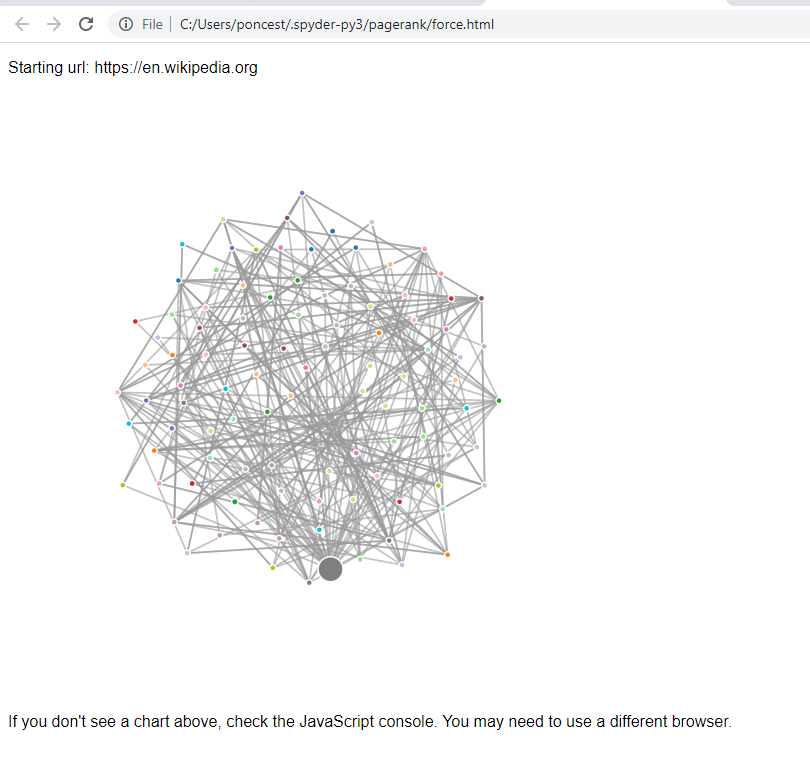


In [ ]:
# Filename = force.js


var width = 600,
    height = 600;

var color = d3.scale.category20();

var dist = (width + height) / 4;

var force = d3.layout.force()
    .charge(-120)
    .linkDistance(dist)
    .size([width, height]);

function getrank(rval) {
  return (rval/2.0) + 3;
}

function getcolor(rval) {
  return color(rval);
}

var svg = d3.select("#chart").append("svg")
    .attr("width", width)
    .attr("height", height);

function loadData(json) {
  force
      .nodes(json.nodes)
      .links(json.links);

    var k = Math.sqrt(json.nodes.length / (width * height));

    force
        .charge(-10 / k)
        .gravity(100 * k)
        .start();

  var link = svg.selectAll("line.link")
      .data(json.links)
      .enter().append("line")
      .attr("class", "link")
      .style("stroke-width", function(d) { return Math.sqrt(d.value); });

  var node = svg.selectAll("circle.node")
      .data(json.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", function(d) { return getrank(d.rank); } )
      .style("fill", function(d) { return getcolor(d.rank); })
      .on("dblclick",function(d) { 
            if ( confirm('Do you want to open '+d.url) ) 
                window.open(d.url,'_new',''); 
            d3.event.stopPropagation();
        })
      .call(force.drag);

  node.append("title")
      .text(function(d) { return d.url; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });

}
loadData(spiderJson);



In [ ]:
# filename = force.html

<!DOCTYPE html>
<html>
  <head>
    <title>Force-Directed Layout</title>
    <script type="text/javascript" src="d3.v2.js"></script>
    <script type="text/javascript" src="spider.js"></script>
    <link type="text/css" rel="stylesheet" href="force.css"/>
  </head>
  <body style="font-family: sans-serif;">
    <script>
        document.write("<p>Starting url: "+spiderJson.nodes[0].url+"</p>");
    </script>
    <div id="chart" style="border:1px"></div>
    <script type="text/javascript" src="force.js"></script>
	<p>If you don't see a chart above, check the JavaScript console. You may
	need to use a different browser.</p>
  </body>
</html>
